# Modelling Part I

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
%matplotlib inline
import glob

sns.set_theme(style='darkgrid')

import statsmodels as sm
from sklearn.metrics import mean_absolute_error, accuracy_score

In [4]:
columns_list = ['year', 'jday', 'month', 'day', 'hour', 'min', 'dt', 'zen', 'dw_solar', 'uw_solar', 'direct_n', 'diffuse', 'dw_ir', 
           'dw_casetemp', 'dw_dometemp', 'uw_irl', 'uw_casetemp', 'uw_dometemp', 'uvb', 'par', 'netsolar', 'netir', 
           'totalnet', 'temp', 'rh', 'windspd', 'winddir', 'pressure']

locations = ['Bondville_IL', 'Boulder_CO', 'Desert_Rock_NV', 'Fort_Peck_MT', 'Goodwin_Creek_MS', 'Penn_State_PA', 'Sioux_Falls_SD']

In [5]:
df_train = {}
df_test = {}
for location in locations:
    print(print(f"Reading Dataframes from {location}'..."))
    
    path = f"D:/Machine_Learning/NOAA/surfrad/to_csv/"
    
    df_train[location] = pd.read_csv(path + f"df_train_{location}.csv")
    df_test[location] = pd.read_csv(path + f"df_test_{location}.csv")
print("Done!")

Reading Dataframes from Bondville_IL'...
None
Reading Dataframes from Boulder_CO'...
None
Reading Dataframes from Desert_Rock_NV'...
None
Reading Dataframes from Fort_Peck_MT'...
None
Reading Dataframes from Goodwin_Creek_MS'...
None
Reading Dataframes from Penn_State_PA'...
None
Reading Dataframes from Sioux_Falls_SD'...
None
Done!


In [6]:
df_train["Bondville_IL"].head()

Unnamed: 0  year  jday  month  day  hour  minute     dt  solar_zenith  ghi  \
0           0  2020     1      1    1     0       0  0.000        105.13 -1.2   
1           1  2020     1      1    1     0       1  0.017        105.31 -1.2   
2           2  2020     1      1    1     0       2  0.033        105.50 -1.2   
3           3  2020     1      1    1     0       3  0.050        105.68 -1.2   
4           4  2020     1      1    1     0       4  0.067        105.86 -1.2   

   ...  dw_ir  uw_ir  uvb  par  netsolar  netir  totalnet  temp_air  \
0  ...  287.4  318.2  0.0  0.0       0.0  -30.8     -30.8       0.2   
1  ...  289.1  318.2  0.0  0.0       0.0  -29.2     -29.2       0.2   
2  ...  288.5  318.2  0.0  0.0       0.0  -29.7     -29.7       0.3   
3  ...  286.4  318.1  0.0  0.0       0.0  -31.7     -31.7       0.3   
4  ...  289.8  318.2  0.0  0.0       0.0  -28.4     -28.4       0.3   

   relative_humidity  pressure  
0               82.8     986.8  
1               82.4     986.8  
2               82.3     986.9  
3               82.3     986.9  
4               82.6     986.9  

[5 rows x 23 columns]

In [7]:
def format_index(data):
    """Create UTC localized DatetimeIndex for the dataframe.
    Parameters
    ----------
    data: Dataframe
        Must contain columns 'year', 'jday', 'hour' and
        'minute'.
    Return
    ------
    data: Dataframe
        Dataframe with a DatetimeIndex localized to UTC.
    """
    year = data.year.apply(str)
    jday = data.jday.apply(lambda x: '{:03d}'.format(x))
    hours = data.hour.apply(lambda x: '{:02d}'.format(x))
    minutes = data.minute.apply(lambda x: '{:02d}'.format(x))
    index = pd.to_datetime(year + jday + hours + minutes, format="%Y%j%H%M")
    data.index = index
    data = data.tz_localize('UTC')

    return data

In [8]:
for location in locations:    
    format_index(df_train[location])
    format_index(df_test[location])
    
    df_train[location].drop(columns=['Unnamed: 0', 'year', 'month', 'day', 'minute', 'dt'], inplace=True)
    df_test[location].drop(columns=['Unnamed: 0', 'year', 'month', 'day', 'minute', 'dt'], inplace=True)

We keep 'jday' and 'hour' as they can be correlated to the solar irradiance!

In [9]:
# Sanity check for datetime index
df_test['Bondville_IL'].index.hour

Int64Index([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
            ...
            23, 23, 23, 23, 23, 23, 23, 23, 23, 23],
           dtype='int64', length=210238)

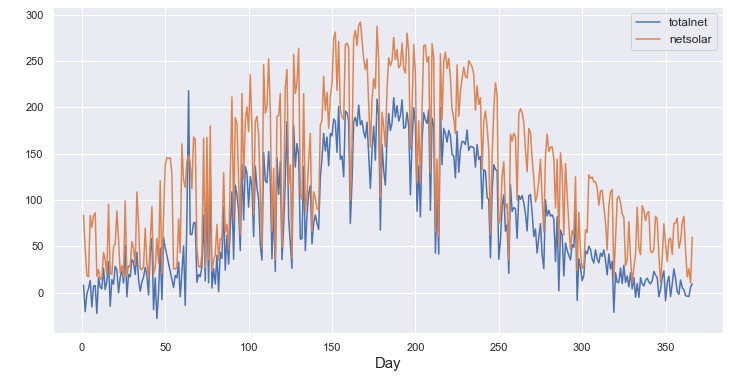

In [18]:
plt.figure(figsize=(12,6))
# sns.lineplot(data=dfs['Bondville_IL'], x='jday', y='totalnet', color='r')
# sns.lineplot(data=dfs['Bondville_IL'], x='jday', y='netsolar', color='green')
sns.lineplot(data=df_train['Bondville_IL'].groupby('jday').mean(), x='jday', y='totalnet')
sns.lineplot(data=df_train['Bondville_IL'].groupby('jday').mean(), x='jday', y='netsolar')

plt.xlabel('Day', fontsize=15)
plt.ylabel(' ', fontsize=15)
plt.legend(['totalnet', 'netsolar'], fontsize=12)
# plt.title('Total Solar Radiation for Julian day 1 of 2020', fontsize=20)
plt.show();

In [ ]:
# Checking null values across all the dataframes
null_dict = {}
for location in locations:
    null_dict[location] = df_train[location].isna().sum()
df_null = pd.DataFrame(null_dict)
df_null

In [10]:
# Quick and dirty interpolation to replace nan values
for location in locations:
    df_train[location].interpolate(method='linear', inplace=True)

In [11]:
null_dict = {}
for location in locations:
    null_dict[location] = df_train[location].isna().sum()
df_null = pd.DataFrame(null_dict)
df_null.isna().sum()

Bondville_IL        0
Boulder_CO          0
Desert_Rock_NV      0
Fort_Peck_MT        0
Goodwin_Creek_MS    0
Penn_State_PA       0
Sioux_Falls_SD      0
dtype: int64

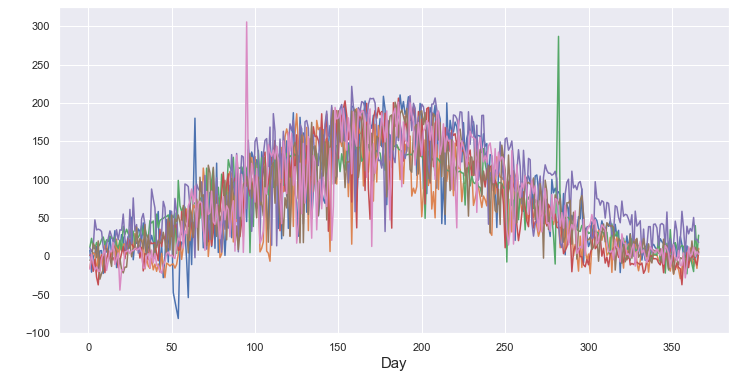

In [17]:
plt.figure(figsize=(12,6))
for location in locations:
    sns.lineplot(data=df_train[location].groupby('jday').mean(), x='jday', y='totalnet')
# sns.lineplot(data=df_train['Bondville_IL'], x='jday', y='totalnet', color='r')
# sns.lineplot(data=df_train['Bondville_IL'], x='jday', y='netsolar', color='green')
# sns.lineplot(data=df_train['Bondville_IL'].groupby('jday').mean(), x='jday', y='totalnet')
# sns.lineplot(data=df_train['Bondville_IL'].groupby('jday').mean(), x='jday', y='netsolar')

plt.xlabel('Day', fontsize=15)
plt.ylabel(' ', fontsize=15)
# plt.legend(['totalnet', 'netsolar'], fontsize=12)
# plt.title('Total Solar Radiation for Julian day 1 of 2020', fontsize=20)
plt.show();

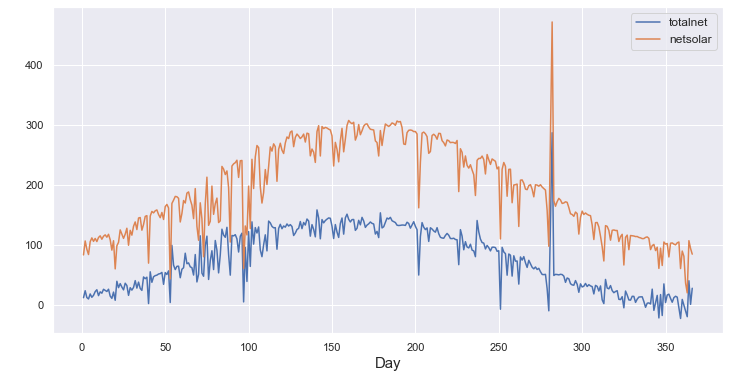

In [22]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_train['Desert_Rock_NV'].groupby('jday').mean(), x='jday', y='totalnet')
sns.lineplot(data=df_train['Desert_Rock_NV'].groupby('jday').mean(), x='jday', y='netsolar')

plt.xlabel('Day', fontsize=15)
plt.ylabel(' ', fontsize=15)
plt.legend(['totalnet', 'netsolar'], fontsize=12)
# plt.title('Total Solar Radiation for Julian day 1 of 2020', fontsize=20)
plt.show();

There are outliers in the data, we need to detect them and clean them.
But for now, lets do standard check on time series data.

## Data Split

In [12]:
# Create Training Data
def data_split(df_train, df_test, location='Bondville_IL', frequency='daily'):
    '''
    Simple function to split data into training/test/validation set
    Also, split based on hourly/daily/monthly aggregates
    '''
    if frequency == 'hourly':
        train = df_train[location].resample('H').mean()
        test_split = int((df_test[location].resample('H').mean().shape[0])/2)        
        val = df_test[location].resample('H').mean()[0:test_split]
        test = df_test[location].resample('H').mean()[test_split:]
        
    elif frequency=='daily':
        train = df_train[location].resample('D').mean()
        test_split = int((df_test[location].resample('D').mean().shape[0])/2)
        val = df_test[location].resample('D').mean()[0:test_split]
        test = df_test[location].resample('D').mean()[test_split:]      
    
    elif frequency=='monthly':
        train = df_train[location].resample('MS').mean()
        test_split = int((df_test[location].resample('MS').mean().shape[0])/2)
        val = df_test[location].resample('MS').mean()[0:test_split]
        test = df_test[location].resample('MS').mean()[test_split:]    
        
    return train, val, test

In [13]:
# split with daily aggregate

train_d, val_d, test_d = {}, {}, {}
train_h, val_h, test_h = {}, {}, {}
for location in locations: 
    train_d[location], val_d[location], test_d[location] = data_split(df_train, df_test, location, frequency='daily')
    train_h[location], val_h[location], test_h[location] = data_split(df_train, df_test, location, frequency='hourly')

### Stationarity Check

In [14]:
# Store rolling mean and standard deviation in a dictionary.
# h: for hourly and d: for daily

roll_mean_h, roll_std_h = {}, {}
roll_mean_d, roll_std_d = {}, {}

for location in locations:  
    # 10 days rolling average
    roll_mean_d[location] = train_d[location].rolling(window=10, center=False).mean()
    roll_std_d[location] = train_d[location].rolling(window=10, center=False).std()
    roll_mean_d[location]['jday'] = train_d[location]['jday']
    roll_std_d[location]['jday'] = train_d[location]['jday']
    
    # 24 hour rolling average
    roll_mean_h[location] = train_h[location].rolling(window=24, center=False).mean()
    roll_std_h[location] = train_h[location].rolling(window=24, center=False).std()
    roll_mean_h[location]['jday'] = train_h[location]['jday']
    roll_std_h[location]['jday'] = train_h[location]['jday']

In [15]:
locations

['Bondville_IL',
 'Boulder_CO',
 'Desert_Rock_NV',
 'Fort_Peck_MT',
 'Goodwin_Creek_MS',
 'Penn_State_PA',
 'Sioux_Falls_SD']

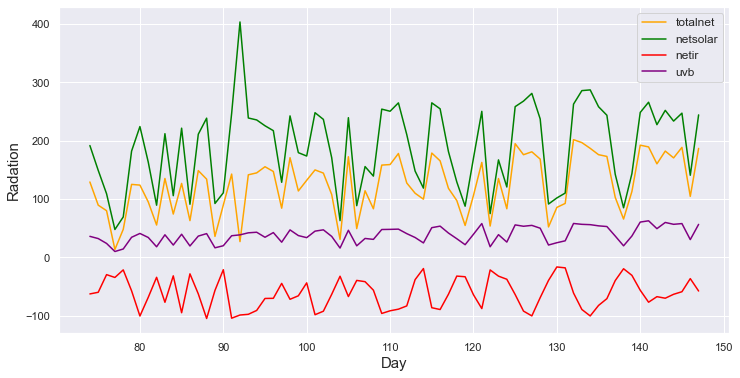

In [16]:
import plotly.graph_objs as go

def roll_mean(train_dict, roll_mean_d):    
   
    fig = go.Figure()
    
#     fig.add_trace(go.Scatter(x=train_dict['Bondville_IL'].index,
#                             y=train_dict['Bondville_IL'].netsolar,
#                             name='Training Data'),       
#                   )
    fig.add_trace(go.Scatter(x=train_dict['Bondville_IL'].index,
                            y=roll_mean_d['Bondville_IL'].netsolar,
                            name='Bondville_IL'),
                  )
    fig.add_trace(go.Scatter(x=train_dict['Bondville_IL'].index,
                            y=roll_mean_d['Boulder_CO'].netsolar,
                            name='Boulder_CO'),
                  )             
                 
    fig.add_trace(go.Scatter(x=train_dict['Bondville_IL'].index,
                            y=roll_mean_d['Desert_Rock_NV'].netsolar,
                            name='Desert_Rock_NV'),
                  )
                  
    fig.add_trace(go.Scatter(x=train_dict['Bondville_IL'].index,
                            y=roll_mean_d['Fort_Peck_MT'].netsolar,
                            name='Fort_Peck_MT'), 
                  )
                  
    fig.add_trace(go.Scatter(x=train_dict['Bondville_IL'].index,
                            y=roll_mean_d['Goodwin_Creek_MS'].netsolar,
                            name='Goodwin_Creek_MS'), 
                  )
                  
    fig.add_trace(go.Scatter(x=train_dict['Bondville_IL'].index,
                            y=roll_mean_d['Penn_State_PA'].netsolar,
                            name='Penn_State_PA'),
                  )
                  
    fig.add_trace(go.Scatter(x=train_dict['Bondville_IL'].index,
                            y=roll_mean_d['Sioux_Falls_SD'].netsolar,
                            name='Sioux_Falls_SD'), 
                  )

    fig.update_layout(title='10 Days Rolling Average of Net Solar Radiation')
                  
    fig.show()

In [17]:
roll_mean(train_d, roll_mean_d)

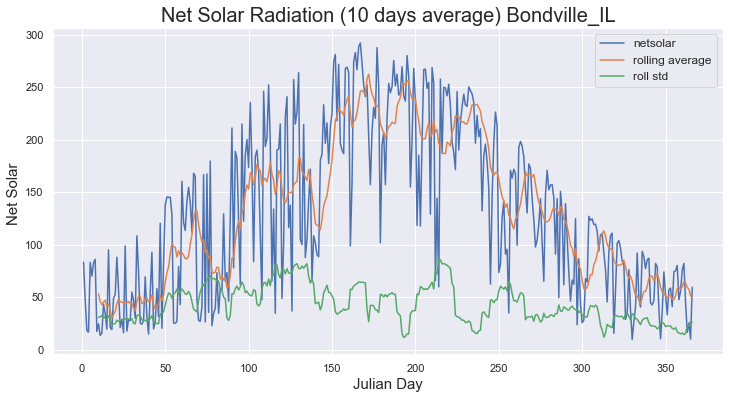

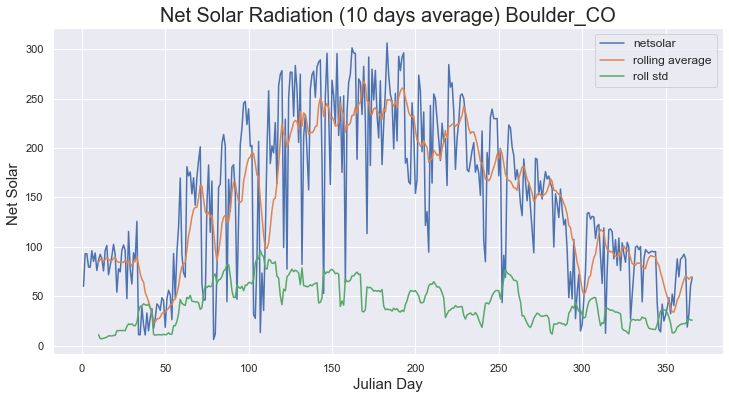

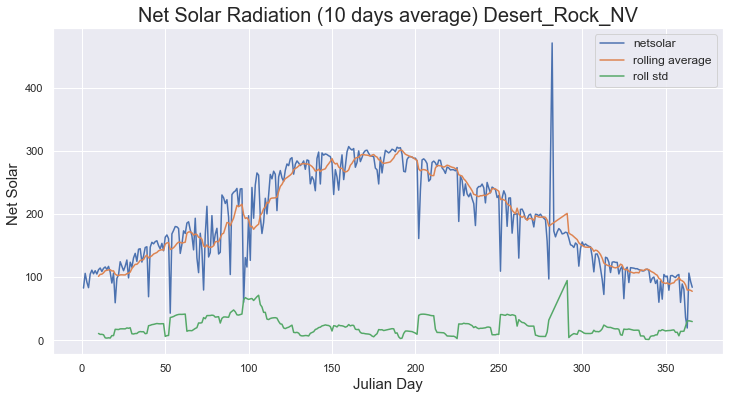

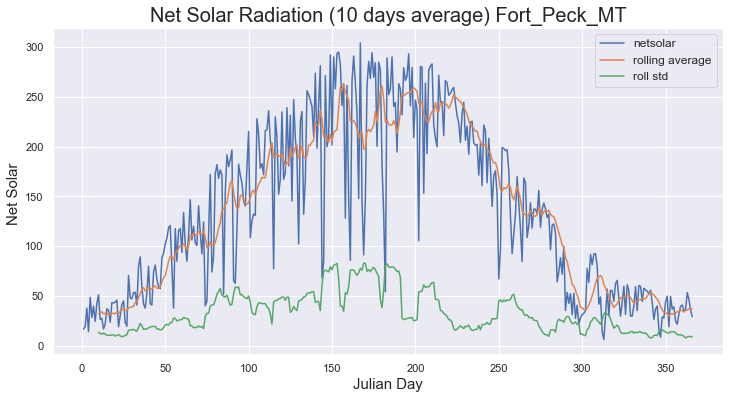

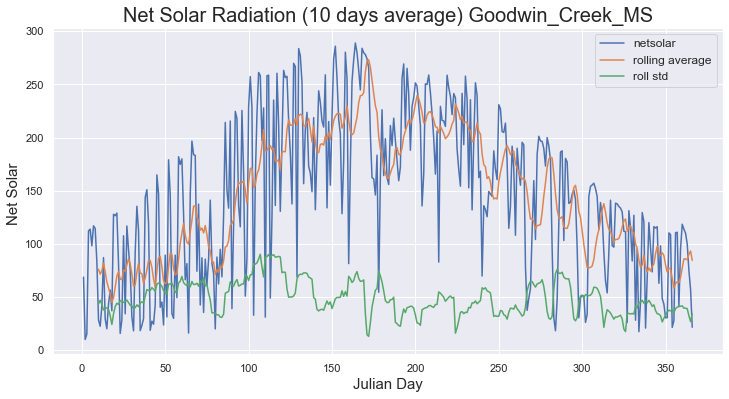

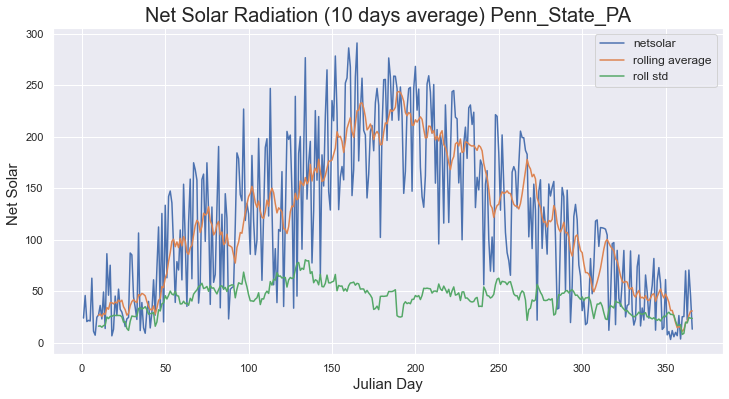

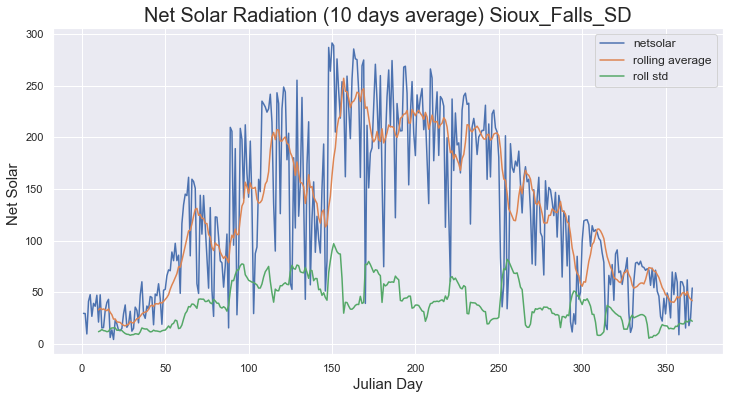

In [59]:
column = 'netsolar'

for location in locations:    
    plt.figure(figsize=(12,6))
    sns.lineplot(data=train_d[location], x='jday', y=column)
    sns.lineplot(data=roll_mean_d[location], x='jday', y=column)
    sns.lineplot(data=roll_std_d[location], x='jday', y=column)

    plt.xlabel('Julian Day', fontsize=15)
    plt.ylabel('Net Solar ', fontsize=15)
    plt.legend([column, 'rolling average', 'roll std'], fontsize=12)
    plt.title(f'Net Solar Radiation (10 days average) {location}', fontsize=20)
    plt.show();

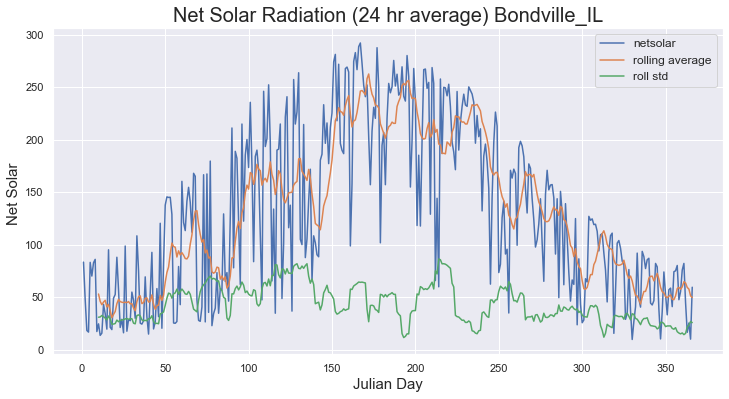

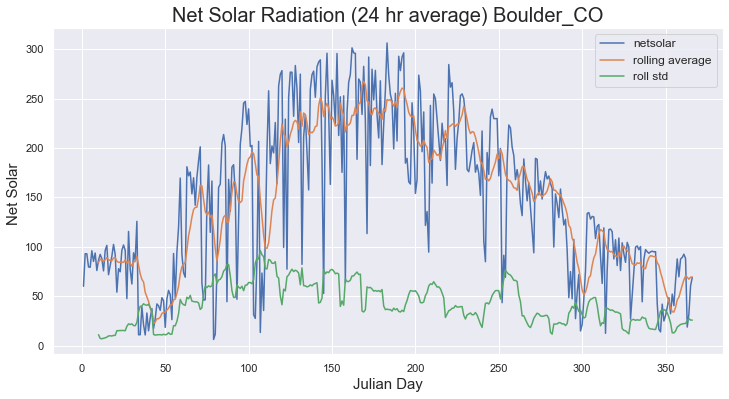

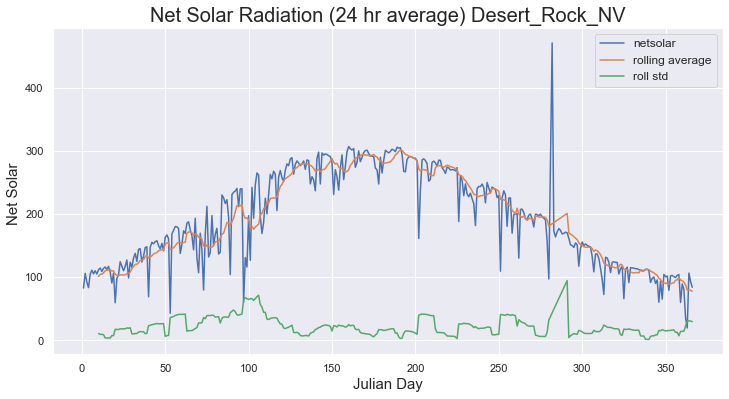

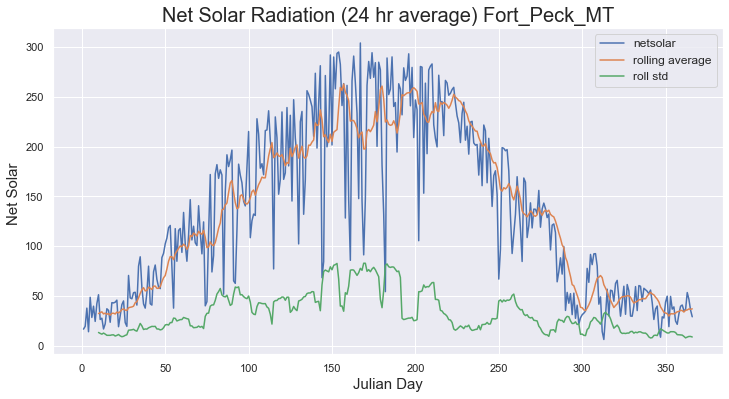

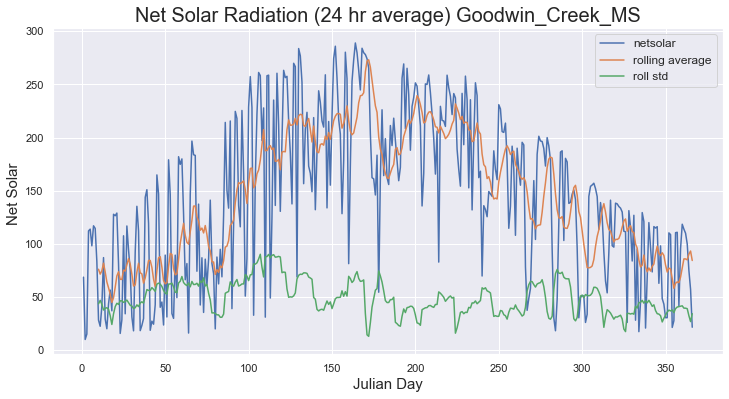

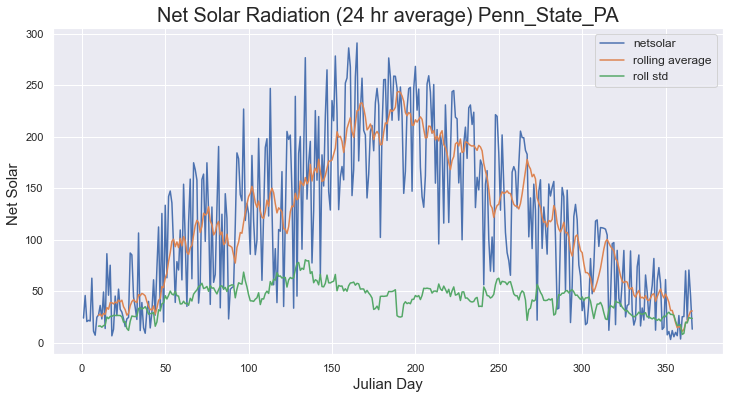

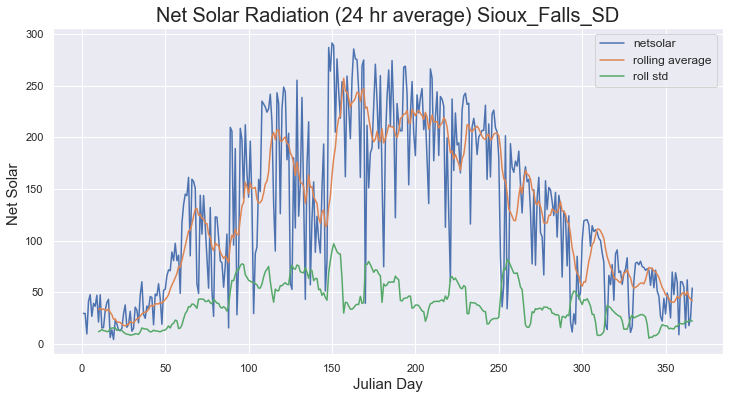

In [60]:
column = 'netsolar'

for location in locations:    
    plt.figure(figsize=(12,6))
    sns.lineplot(data=train_d[location], x='jday', y=column)
    sns.lineplot(data=roll_mean_d[location], x='jday', y=column)
    sns.lineplot(data=roll_std_d[location], x='jday', y=column)

    plt.xlabel('Julian Day', fontsize=15)
    plt.ylabel('Net Solar ', fontsize=15)
    plt.legend([column, 'rolling average', 'roll std'], fontsize=12)
    plt.title(f'Net Solar Radiation (24 hr average) {location}', fontsize=20)
    plt.show();

### Test for Stationarity

In [81]:
train_d[location].fillna(0, inplace=True)
train_h[location].fillna(0, inplace=True)

In [70]:
from statsmodels.tsa.stattools import adfuller

In [71]:
def adf_test(df, signif=0.05):
    dftest = adfuller(df, autolag='AIC')
    adf = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', '# Observations'])
    for key, value in dftest[4].items():
        adf['Critical Value (%s) '%key] = value
    print(adf)
    
    p = adf['p-value']
    if p <= signif:
        print(f"Series is Stationary")
    else:
        print(f"Series is Non-Stationary")

In [79]:
for location in locations:
    print('\n'+location)
    adf_test(train_d[location].netsolar)


Bondville_IL
Test Statistic            -1.702851
p-value                    0.429644
#Lags Used                10.000000
# Observations           355.000000
Critical Value (1%)       -3.448906
Critical Value (5%)       -2.869716
Critical Value (10%)      -2.571126
dtype: float64
Series is Non-Stationary

Boulder_CO
Test Statistic            -1.337090
p-value                    0.612038
#Lags Used                12.000000
# Observations           353.000000
Critical Value (1%)       -3.449011
Critical Value (5%)       -2.869763
Critical Value (10%)      -2.571151
dtype: float64
Series is Non-Stationary

Desert_Rock_NV
Test Statistic            -0.601915
p-value                    0.870549
#Lags Used                 9.000000
# Observations           356.000000
Critical Value (1%)       -3.448853
Critical Value (5%)       -2.869693
Critical Value (10%)      -2.571114
dtype: float64
Series is Non-Stationary

Fort_Peck_MT
Test Statistic            -0.952506
p-value                    0.770

In [82]:
for location in locations:
    print('\n'+location)
    adf_test(train_h[location].netsolar)


Bondville_IL
Test Statistic          -7.171742e+00
p-value                  2.792983e-10
#Lags Used               2.800000e+01
# Observations           8.755000e+03
Critical Value (1%)     -3.431097e+00
Critical Value (5%)     -2.861870e+00
Critical Value (10%)    -2.566946e+00
dtype: float64
Series is Stationary

Boulder_CO
Test Statistic          -7.019834e+00
p-value                  6.586909e-10
#Lags Used               2.600000e+01
# Observations           8.757000e+03
Critical Value (1%)     -3.431097e+00
Critical Value (5%)     -2.861870e+00
Critical Value (10%)    -2.566946e+00
dtype: float64
Series is Stationary

Desert_Rock_NV
Test Statistic             -4.673061
p-value                     0.000095
#Lags Used                 28.000000
# Observations           8755.000000
Critical Value (1%)        -3.431097
Critical Value (5%)        -2.861870
Critical Value (10%)       -2.566946
dtype: float64
Series is Stationary

Fort_Peck_MT
Test Statistic          -5.776694e+00
p-value

Data resampled to daily average is is not stationary, but resampled to hourly average stationary as indicated by extremely low p-value( << 0.05 ). 

### Test for causality

In [84]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [266]:
locations

['Bondville_IL',
 'Boulder_CO',
 'Desert_Rock_NV',
 'Fort_Peck_MT',
 'Goodwin_Creek_MS',
 'Penn_State_PA',
 'Sioux_Falls_SD']

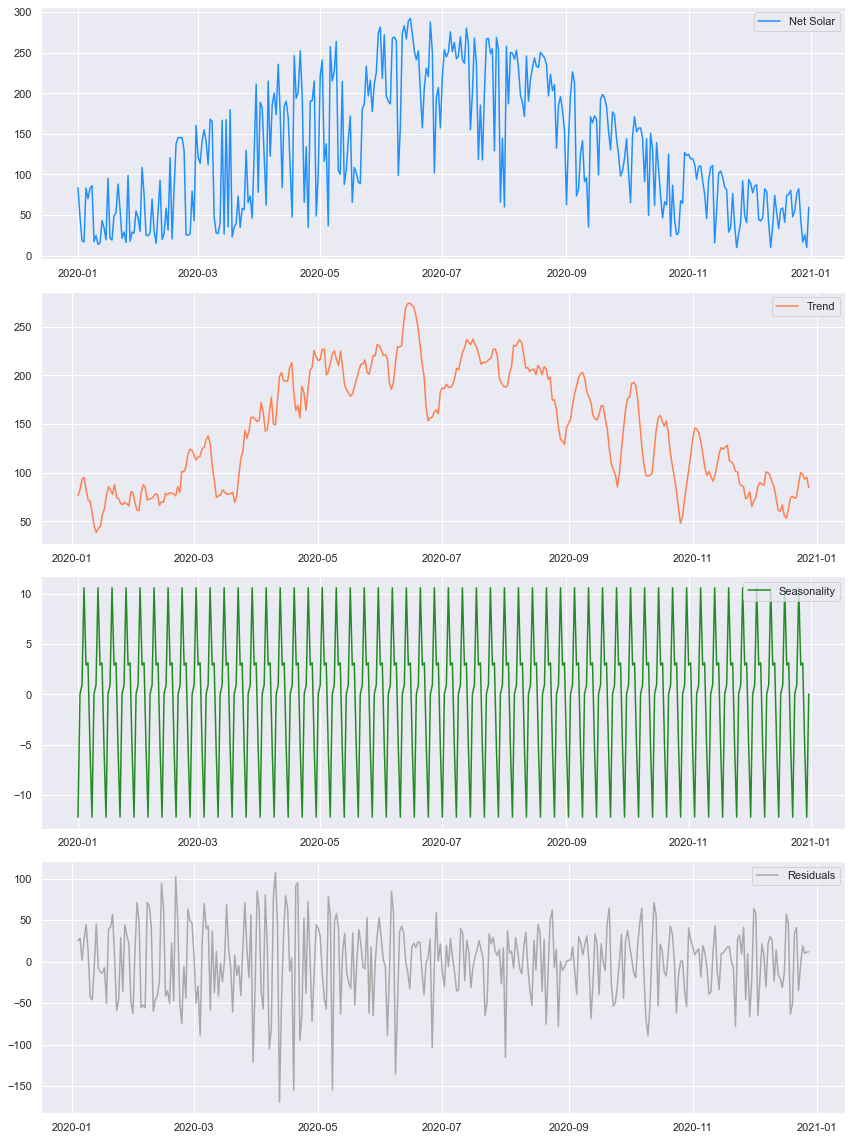

In [267]:
decomposition_d = seasonal_decompose(train_d['Goodwin_Creek_MS'].netsolar)

# Gather the trend, seasonality, and residuals 
trend = decomposition_d.trend
seasonal = decomposition_d.seasonal
residual = decomposition_d.resid

# Plot gathered statistics
plt.figure(figsize=(12,16))
plt.subplot(411)
plt.plot(train_d['Bondville_IL'].netsolar, label='Net Solar', color='dodgerblue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='coral')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='forestgreen')
plt.legend(loc='upper right')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='darkgrey')
plt.legend(loc='best')
plt.tight_layout()


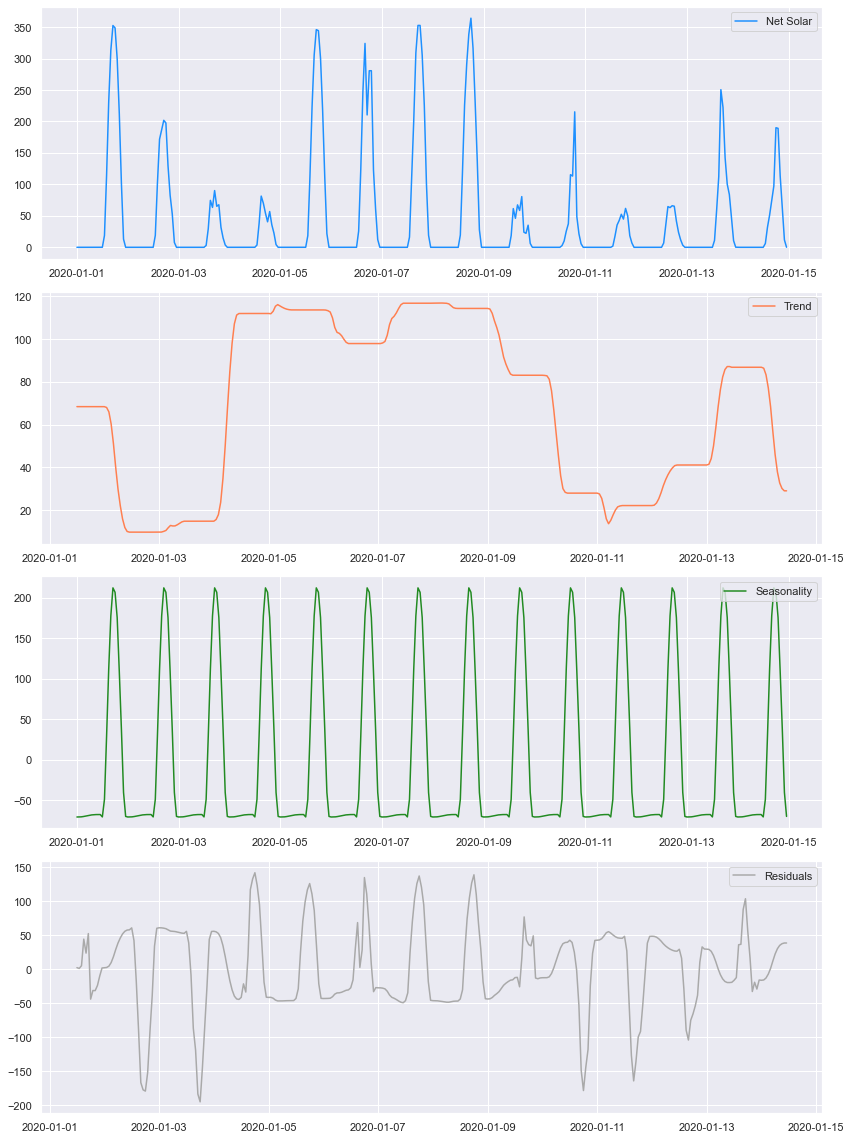

In [268]:
decomposition_h = seasonal_decompose(train_h['Goodwin_Creek_MS'].netsolar[0:336,])  # upto 14 days

# Gather the trend, seasonality, and residuals 
trend = decomposition_h.trend
seasonal = decomposition_h.seasonal
residual = decomposition_h.resid

# Plot gathered statistics
plt.figure(figsize=(12,16))
plt.subplot(411)
plt.plot(train_h['Bondville_IL'].netsolar[0:336,], label='Net Solar', color='dodgerblue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='coral')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='forestgreen')
plt.legend(loc='upper right')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='darkgrey')
plt.legend(loc='best')
plt.tight_layout()

Although, the adfuller test tells us no seasonality in the hourly dataset, there seems to be some seasonality in the dataset.

# Modelling

In [18]:
# Extract a univarate data for Arima modelling, hour and day
# We will start this experiment on one of the location

train_d_1d = train_d['Goodwin_Creek_MS']['netsolar']
test_d_1d = test_d['Goodwin_Creek_MS']['netsolar']

train_h_1d = train_h['Goodwin_Creek_MS']['netsolar']
test_h_1d = test_h['Goodwin_Creek_MS']['netsolar']

train_d_1d.shape, test_d_1d.shape, train_h_1d.shape, test_h_1d.shape

((366,), (74,), (8784,), (1764,))

In [19]:
# val_h = df_test['Bondville_IL'].resample('H').mean()['netsolar'][0:1752]
# test_h = df_test['Bondville_IL'].resample('H').mean()['netsolar'][1752:]

# train_d = df_train['Bondville_IL'].resample('D').mean()['netsolar'].fillna(0)
# val_d = df_test['Bondville_IL'].resample('D').mean()['netsolar'][0:1752]
# test_d = df_test['Bondville_IL'].resample('D').mean()['netsolar'][1752:]

# val_h.fillna(0, inplace=True)
# val_d.fillna(0, inplace=True)

In [20]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

<AxesSubplot:>

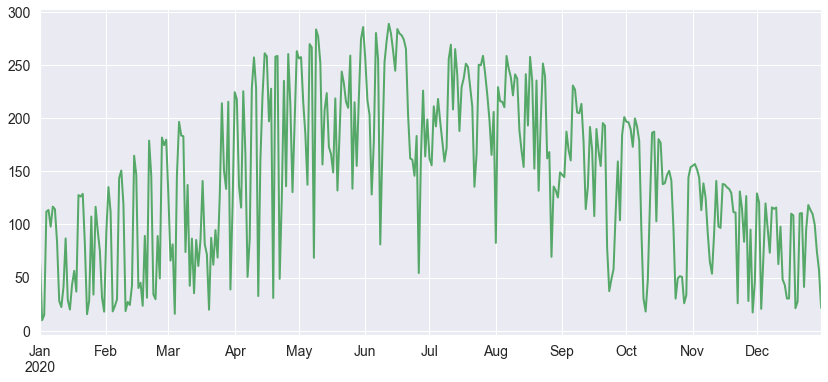

In [21]:
train_d_1d.plot(figsize=(14,6), linewidth=2, fontsize=14, color='g')

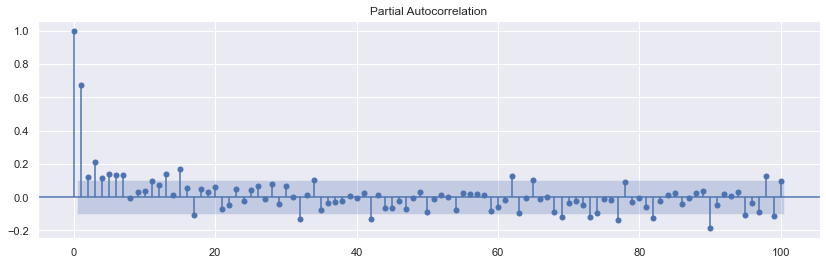

In [22]:
fig, ax = plt.subplots(figsize=(14,4))
plot_pacf(train_d_1d, ax=ax, lags=100);

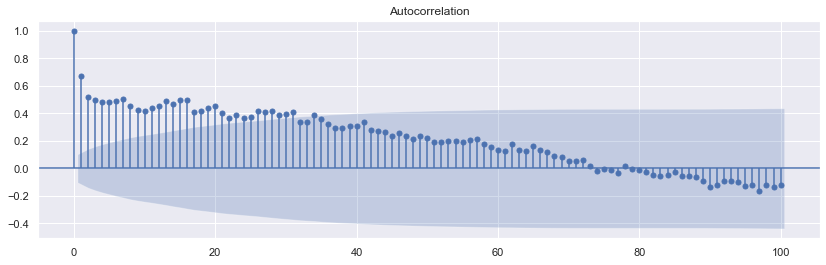

In [23]:
fig, ax = plt.subplots(figsize=(14,4))
plot_acf(train_d_1d, ax=ax, lags=100);

### ARIMA

In [24]:
from statsmodels.tsa.arima.model import ARIMA

C:\Users\smnge\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                               SARIMAX Results                                
Dep. Variable:               netsolar   No. Observations:                  366
Model:                 ARIMA(5, 0, 1)   Log Likelihood               -1961.891
Date:                Tue, 15 Jun 2021   AIC                           3939.782
Time:                        15:40:18   BIC                           3971.003
Sample:                    01-01-2020   HQIC                          3952.189
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        139.6800     44.136      3.165      0.002      53.176     226.184
ar.L1          1.3526      0.065     20.873      0.000       1.226       1.480
ar.L2         -0.4694      0.081     -5.784      0.0

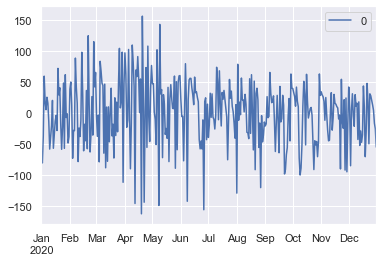

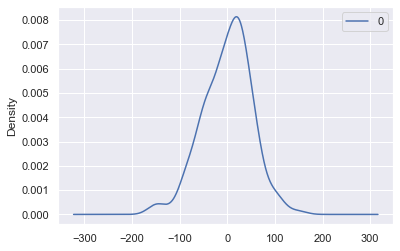

In [25]:
arima = ARIMA(train_d_1d, order=(5,0,1)).fit()
print(arima.summary())
residuals = pd.DataFrame(arima.resid)
residuals.plot()
residuals.plot(kind='kde')
print(residuals.describe())

In [26]:
df_arima_pred = pd.DataFrame(val_d['Bondville_IL'].netsolar, columns=['netsolar'])
pred_arima = arima.predict(start='2021-01-01', end='2021-08-01')
pred_arima_np = pd.Series(np.array(pred_arima).reshape(-1))

df_arima_temp = pd.DataFrame(df_arima_pred).reset_index()
df_arima_temp['predicted'] = pd.Series(pred_arima_np, index = df_arima_temp.index)

df_arima_pred['predict_arima'] = df_arima_temp['predicted'].values
df_arima_pred.head()

netsolar  predict_arima
2021-01-01  11.735000      60.210796
2021-01-02  20.541458      79.190262
2021-01-03  14.311597      81.518166
2021-01-04  21.697500      83.984605
2021-01-05  26.341181      83.526857

In [27]:
import plotly.graph_objs as go

def arima_forecast(train_df, val_df, pred_df):    
   
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(x=train_df.index,
                            y=train_df,
                            name='Training Data'),       
                         )
    fig.add_trace(go.Scatter(x=val_df.index,
                            y=val_df,
                            name='Ground Truth'),       
                         )
    fig.add_trace(go.Scatter(x=pred_df.index,
                            y=pred_df,
                            name='Forecast'),       
                         )


    fig.update_layout(title='Forecast of Net Solar Radiation')
    fig.show()

In [28]:
arima_forecast(train_d_1d, val_d['Bondville_IL'].netsolar, df_arima_pred['predict_arima'] )

So, we can see that the ARIMA model is not so effective in predicting in realistic manner. Although, we saw some seasonality aspect in the data but we didnt account for it in the modelling yet.In the next step, we will try to experiment with SARIMAX which will account for the seasonal aspect of the data.

### SARIMAX

In [29]:
import statsmodels.api as sm

In [30]:
sarimax1 = sm.tsa.statespace.SARIMAX(train_d_1d, 
                                    #exog = X, 
                                    order=(1,1,1),
                                    seasonal_order=(2,1,2,12), 
                                    )

# Fit the model and print results
sarimax1_results = sarimax1.fit()
print(sarimax1_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3450      0.060      5.761      0.000       0.228       0.462
ma.L1         -0.9220      0.029    -31.553      0.000      -0.979      -0.865
ar.S.L12       0.5884      0.712      0.826      0.409      -0.807       1.984
ar.S.L24      -0.0455      0.074     -0.613      0.540      -0.191       0.100
ma.S.L12      -1.5452      0.706     -2.189      0.029      -2.929      -0.162
ma.S.L24       0.5788      0.668      0.867      0.386      -0.730       1.887
sigma2      2821.1281    190.320     14.823      0.000    2448.108    3194.148


C:\Users\smnge\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



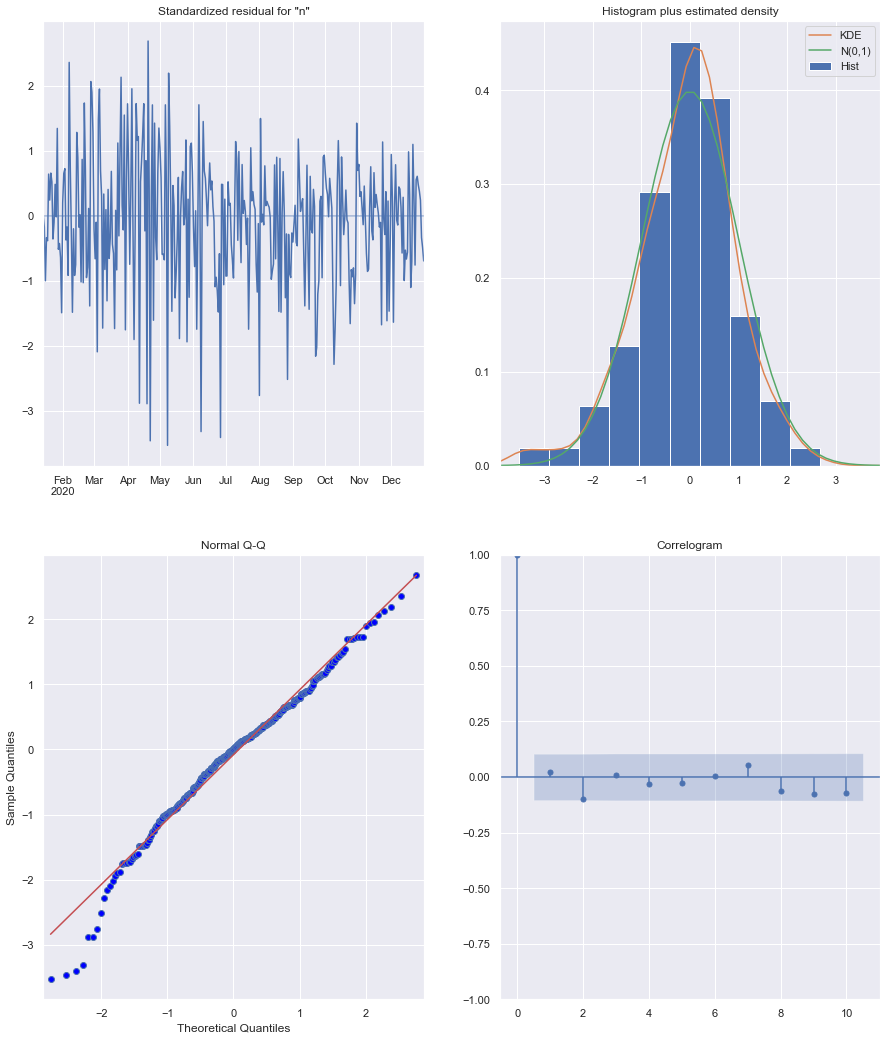

In [31]:
# Call plot_diagnostics() on the results calculated above 
sarimax1_results.plot_diagnostics(figsize=(15, 18))
plt.show()

In [32]:
pred_sarimax1 = sarimax1_results.predict(start='2021-01-01', end='2021-08-01')
pred_sarimax1_np = pd.Series(np.array(pred_sarimax1).reshape(-1))

df_sarimax_temp = pd.DataFrame(df_arima_pred.reset_index())
df_sarimax_temp['predicted'] = pd.Series(pred_sarimax1_np, index = df_arima_temp.index)

df_arima_pred['predict_sarimax1'] = df_sarimax_temp['predicted'].values
df_arima_pred.head()

netsolar  predict_arima  predict_sarimax1
2021-01-01  11.735000      60.210796         62.713554
2021-01-02  20.541458      79.190262         67.471738
2021-01-03  14.311597      81.518166         80.256039
2021-01-04  21.697500      83.984605         65.358192
2021-01-05  26.341181      83.526857         75.356192

In [33]:
import plotly.graph_objs as go

def sarima_forecast(train_df, val_df, pred1, pred2):    
   
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(x=train_df.index,
                            y=train_df,
                            name='Training Data'),       
                         )
    fig.add_trace(go.Scatter(x=val_df.index,
                            y=val_df,
                            name='Ground Truth'),       
                         )
    fig.add_trace(go.Scatter(x=pred1.index,
                            y=pred1,
                            name='Previous Forecast'),       
                         )
    fig.add_trace(go.Scatter(x=pred2.index,
                            y=pred2,
                            name='New Forecast'),       
                         )


    fig.update_layout(title='Forecast of Net Solar Radiation')
    fig.show()

In [34]:
sarima_forecast(train_d_1d, val_d['Goodwin_Creek_MS'].netsolar, df_arima_pred['predict_arima'],
               df_arima_pred['predict_sarimax1'])

Comparing to Arima, the sarimax model seems to better capture the trend in the granular manner. However, the current model hasn't yet able to generalize it better. In terms of generalization, the arima model is okay though it just depicts a linear style trend.

### Hyperparameter Searching

In [35]:
import itertools
import warnings
warnings.filterwarnings("ignore")

p = d = q = range(0,2)
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q)) ]
print('Examples of parameter for SARIMAX...')
print('SARIMAX: {} x {}'.format(pdq[1], pdqs[1]))

Examples of parameter for SARIMAX...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)


In [224]:
def sarimax_tuning(timeseries, seasonal_period):
    ''' 
    A simple function to grid search optimum paramters for SARIMAX
    An example of SARIMAX parameters: (0, 0, 1) x (0, 0, 1, 12)
    '''
    p = d = q = range(0,2)
    pdq = list(itertools.product(p, d, q))
    pdqs = [(x[0], x[1], x[2], seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    for param in pdq:
        for param_seasonal in pdqs:               
            try:
                model = sm.tsa.statespace.SARIMAX(timeseries,
                                                 order=param,
                                                 seasonal_order=param_seasonal,
                                                 enforce_stationarity=False,
                                                 enforce_invertibility=False
                                                 )
                results = model.fit()

                if results.aic < mini:
                    param_mini = param
                    param_seasonal_mini = param_seasonal
                    #print(f'SARIMAX{param}x{param_seasonal} - AIC:{results.aic}')
            except:
                continue
    print(f'The set of parameters with the minimum AIC is: SARIMAX{param_mini}x{param_seasonal_mini}-AIC:{mini}')

In [225]:
sarimax_tuning(train_d_1d, 12)

The set of parameters with the minimum AIC is: SARIMAX(1, 1, 1)x(1, 1, 1, 12)-AIC:inf


In [286]:
p = q = (0, 1, 2)
d = 0
pdq = [(ar, d, ma) for ar in p for ma in q]
pdqs = [(c[0], d, c[2], 12) for c in pdq]

# Iterate and try models:
combo, value = (None, None)
for pdq_combo in pdq:
    for pdqs_combo in pdqs:
        try:
            model = sm.tsa.statespace.SARIMAX(train_d_1d,
                                             order=pdq_combo,
                                             seasonal_order=pdqs_combo,
                                             enforce_stationarity=False,
                                             enforce_invertibility=False
                                             )
            output = model.fit()
            if value is None or output.aic < value:
                combo, value = ((pdq_combo, pdqs_combo), output.aic)
                #print('Sarima Combos:', (pdq_combo, pdqs_combo), 'AIC:', output.aic)

        except ValueError:
            pass
print(f'\m{"*"*20}\nOptimal Sarima order: {combo}')  

\m********************
Optimal Sarima order: ((1, 0, 2), (0, 0, 2, 12))


In [36]:
sarimax2 = sm.tsa.statespace.SARIMAX(train_d_1d, 
                                    #exog = X, 
                                    order=(1,0,2),
                                    seasonal_order=(0,0,2,12), 
                                    enforce_stationarity=False,
                                    enforce_invertibility=False
                                    )

# Fit the model and print results
sarimax2_results = sarimax2.fit()
print(sarimax2_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9992      0.002    407.352      0.000       0.994       1.004
ma.L1         -0.5521      0.051    -10.885      0.000      -0.651      -0.453
ma.L2         -0.3161      0.048     -6.604      0.000      -0.410      -0.222
ma.S.L12      -0.0502      0.056     -0.902      0.367      -0.159       0.059
ma.S.L24      -0.0592      0.060     -0.983      0.326      -0.177       0.059
sigma2      2713.0881    210.724     12.875      0.000    2300.077    3126.100


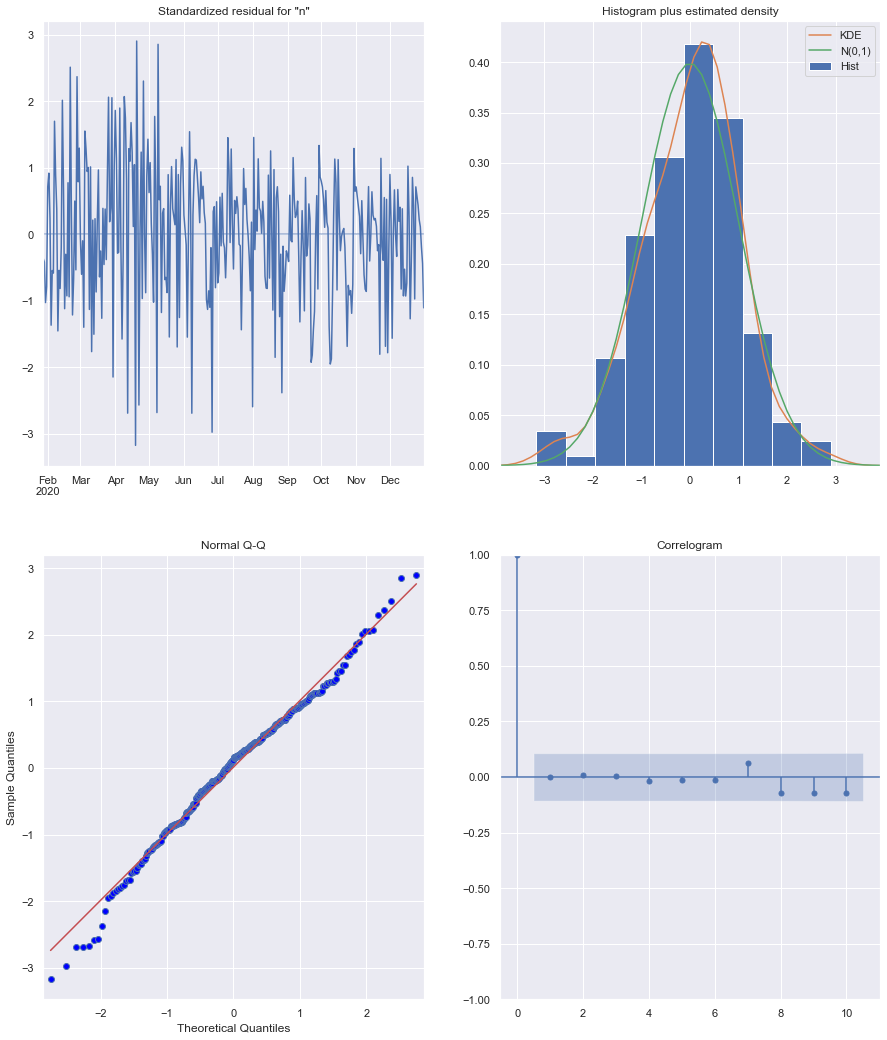

In [37]:
# Call plot_diagnostics() on the results calculated above 
sarimax2_results.plot_diagnostics(figsize=(15, 18))
plt.show()

In [38]:
pred_sarimax2 = sarimax2_results.predict(start='2021-01-01', end='2021-08-01')
pred_sarimax2_np = pd.Series(np.array(pred_sarimax2).reshape(-1))

df_sarimax_temp = pd.DataFrame(df_arima_pred.reset_index())
df_sarimax_temp['predicted'] = pd.Series(pred_sarimax2_np, index = df_arima_temp.index)

df_arima_pred['predict_sarimax2'] = df_sarimax_temp['predicted'].values
df_arima_pred.head()

netsolar  predict_arima  predict_sarimax1  predict_sarimax2
2021-01-01  11.735000      60.210796         62.713554         56.983548
2021-01-02  20.541458      79.190262         67.471738         71.470392
2021-01-03  14.311597      81.518166         80.256039         70.913692
2021-01-04  21.697500      83.984605         65.358192         78.150055
2021-01-05  26.341181      83.526857         75.356192         72.991002

In [39]:
sarima_forecast(train_d_1d, val_d['Bondville_IL'].netsolar, df_arima_pred['predict_sarimax1'],
               df_arima_pred['predict_sarimax2'])

In [240]:
p = q = (0, 1, 2)
d = 0
pdq = [(ar, d, ma) for ar in p for ma in q]
pdqs = [(c[0], d, c[2], 30) for c in pdq]

# Iterate and try models:
combo, value = (None, None)
for pdq_combo in pdq:
    for pdqs_combo in pdqs:
        try:
            model = sm.tsa.statespace.SARIMAX(train_d_1d,
                                             order=pdq_combo,
                                             seasonal_order=pdqs_combo,
                                             enforce_stationarity=False,
                                             enforce_invertibility=False
                                             )
            output = model.fit()
            if value is None or output.aic < value:
                combo, value = ((pdq_combo, pdqs_combo), output.aic)
                #print('Sarima Combos:', (pdq_combo, pdqs_combo), 'AIC:', output.aic)

        except ValueError:
            pass
print(f'\m{"*"*20}\nOptimal Sarima order: {combo}')  

\m********************
Optimal Sarima order: ((1, 0, 2), (1, 0, 2, 30))


In [40]:
sarimax3 = sm.tsa.statespace.SARIMAX(train_d_1d, 
                                    #exog = X, 
                                    order=(1,0,2),
                                    seasonal_order=(1,0,2,30), 
                                    enforce_stationarity=False,
                                    enforce_invertibility=False
                                    )

# Fit the model and print results
sarimax3_results = sarimax3.fit()
print(sarimax3_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9987      0.003    313.125      0.000       0.992       1.005
ma.L1         -0.5627      0.056    -10.096      0.000      -0.672      -0.453
ma.L2         -0.3065      0.051     -6.007      0.000      -0.407      -0.207
ar.S.L30      -0.0620      0.147     -0.421      0.674      -0.351       0.227
ma.S.L30       0.1555      0.159      0.976      0.329      -0.157       0.468
ma.S.L60       0.0341      0.072      0.474      0.635      -0.107       0.175
sigma2      2773.5439    235.101     11.797      0.000    2312.755    3234.333


In [41]:
pred_sarimax3 = sarimax3_results.predict(start='2021-01-01', end='2021-08-01')
pred_sarimax3_np = pd.Series(np.array(pred_sarimax2).reshape(-1))

df_sarimax_temp = pd.DataFrame(df_arima_pred.reset_index())
df_sarimax_temp['predicted'] = pd.Series(pred_sarimax3_np, index = df_arima_temp.index)

df_arima_pred['predict_sarimax3'] = df_sarimax_temp['predicted'].values
df_arima_pred.head()

netsolar  predict_arima  predict_sarimax1  predict_sarimax2  \
2021-01-01  11.735000      60.210796         62.713554         56.983548   
2021-01-02  20.541458      79.190262         67.471738         71.470392   
2021-01-03  14.311597      81.518166         80.256039         70.913692   
2021-01-04  21.697500      83.984605         65.358192         78.150055   
2021-01-05  26.341181      83.526857         75.356192         72.991002   

            predict_sarimax3  
2021-01-01         56.983548  
2021-01-02         71.470392  
2021-01-03         70.913692  
2021-01-04         78.150055  
2021-01-05         72.991002

In [42]:
sarima_forecast(train_d_1d, val_d['Bondville_IL'].netsolar, df_arima_pred['predict_sarimax1'],
               df_arima_pred['predict_sarimax3'])

In [43]:
sarimax4 = sm.tsa.statespace.SARIMAX(train_d_1d, 
                                    #exog = X, 
                                    order=(1,1,1),
                                    seasonal_order=(0,0,2,12), 
                                    enforce_stationarity=False,
                                    enforce_invertibility=False
                                    )

# Fit the model and print results
sarimax4_results = sarimax4.fit()
print(sarimax4_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3266      0.058      5.674      0.000       0.214       0.439
ma.L1         -0.9140      0.025    -36.716      0.000      -0.963      -0.865
ma.S.L12      -0.0377      0.053     -0.716      0.474      -0.141       0.065
ma.S.L24      -0.0630      0.060     -1.058      0.290      -0.180       0.054
sigma2      2737.6066    205.503     13.321      0.000    2334.828    3140.385


In [44]:
pred_sarimax4 = sarimax4_results.predict(start='2021-01-01', end='2021-08-01')
pred_sarimax4_np = pd.Series(np.array(pred_sarimax2).reshape(-1))

df_sarimax_temp = pd.DataFrame(df_arima_pred.reset_index())
df_sarimax_temp['predicted'] = pd.Series(pred_sarimax4_np, index = df_arima_temp.index)

df_arima_pred['predict_sarimax4'] = df_sarimax_temp['predicted'].values
df_arima_pred.head()

netsolar  predict_arima  predict_sarimax1  predict_sarimax2  \
2021-01-01  11.735000      60.210796         62.713554         56.983548   
2021-01-02  20.541458      79.190262         67.471738         71.470392   
2021-01-03  14.311597      81.518166         80.256039         70.913692   
2021-01-04  21.697500      83.984605         65.358192         78.150055   
2021-01-05  26.341181      83.526857         75.356192         72.991002   

            predict_sarimax3  predict_sarimax4  
2021-01-01         56.983548         56.983548  
2021-01-02         71.470392         71.470392  
2021-01-03         70.913692         70.913692  
2021-01-04         78.150055         78.150055  
2021-01-05         72.991002         72.991002

In [45]:
sarima_forecast(train_d_1d, val_d['Bondville_IL'].netsolar, df_arima_pred['predict_sarimax1'],
               df_arima_pred['predict_sarimax4'])

In [46]:
mae_arima = mean_absolute_error(df_arima_pred['netsolar'], df_arima_pred['predict_arima'])
mae_sarimax1 = mean_absolute_error(df_arima_pred['netsolar'], df_arima_pred['predict_sarimax1'])
mae_sarimax2 = mean_absolute_error(df_arima_pred['netsolar'], df_arima_pred['predict_sarimax2'])
mae_sarimax3 = mean_absolute_error(df_arima_pred['netsolar'], df_arima_pred['predict_sarimax3'])

print(f'Mean Absolute Error ARIMA : {mae_arima}')
print(f'Mean Absolute Error SARIMAX 1: {mae_sarimax1}')
print(f'Mean Absolute Error SARIMAX 2: {mae_sarimax2}')
print(f'Mean Absolute Error SARIMAX 3: {mae_sarimax3}')

Mean Absolute Error ARIMA : 45.45806401208568
Mean Absolute Error SARIMAX 1: 46.180455691716816
Mean Absolute Error SARIMAX 2: 43.12618783148651
Mean Absolute Error SARIMAX 3: 43.12618783148651


# Conclusion

Current test shows that both ARIMA and SARIMAX are not able to forecast well for this data. One reasoning behind this could be lack of more historic data as there is siginificant seasonality in the data. It would be interesting if we add more yearly data, if the SARIMAX will perform better. For now the forecast test will be focused on neural net based architecture called LSTM which will be provided in a separate notebook.

### Appendix

In [ ]:
import math

def fill_nan(df, location):
    '''
    Function to derive netsolar from totalnet using linear regression and vice-versa
    '''    
    df = df.replace(to_replace=-9999.9, value=np.nan)
    
    if location == 'Bondville_IL':
        df['totalnet_fill'] = 0.77 * df.netsolar - 22 
        df['netsolar_fill'] = (df.totalnet + 22)/0.77        
        
    elif location == 'Boulder_CO':
        df['totalnet_fill'] = 0.7 * df.netsolar - 42  
        df['netsolar_fill'] = (df.totalnet + 42)/0.7
        
    elif location == 'Desert_Rock_NV':
        df['totalnet_fill'] = 0.6 * df.netsolar - 48
        df['netsolar_fill'] = (df.totalnet + 48)/0.6
    
    elif location == 'Fort_Peck_MT':
        df['totalnet_fill'] = 0.75 * df.netsolar - 33
        df['netsolar_fill'] = (df.totalnet + 33)/0.75
        
    elif location == 'Goodwin_Creek_MS':
        df['totalnet_fill'] = 0.76 * df.netsolar - 17
        df['netsolar_fill'] = (df.totalnet + 17)/0.76
        
    elif location == 'Penn_State_PA':
        df['totalnet_fill'] = 0.75 * df.netsolar - 21 
        df['netsolar_fill'] = (df.totalnet + 21)/0.75
        
    else:
        df['totalnet_fill'] = 0.78 * df.netsolar - 29
        df['netsolar_fill'] = (df.totalnet + 29)/0.78
        
    df['totalnet'] = df['totalnet'].fillna(df['totalnet_fill'])
    df['netsolar'] = df['netsolar'].fillna(df['netsolar_fill'])
    
    return df